In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import numba
from numba import njit

In [11]:
def da1dt(t, a):
    k = 1
    vx, x, vz, z = a
    return [-k/x * vz, vx, k/x * vx, vz]
a_0 = (0.06, 0.1, 0.08, 0.0)

In [12]:
t=np.linspace(0, 10, 1000)
sol = odeint(da1dt, y0=a_0, t=t, tfirst=True, full_output=True)
# sol[1]["tolsf"].T

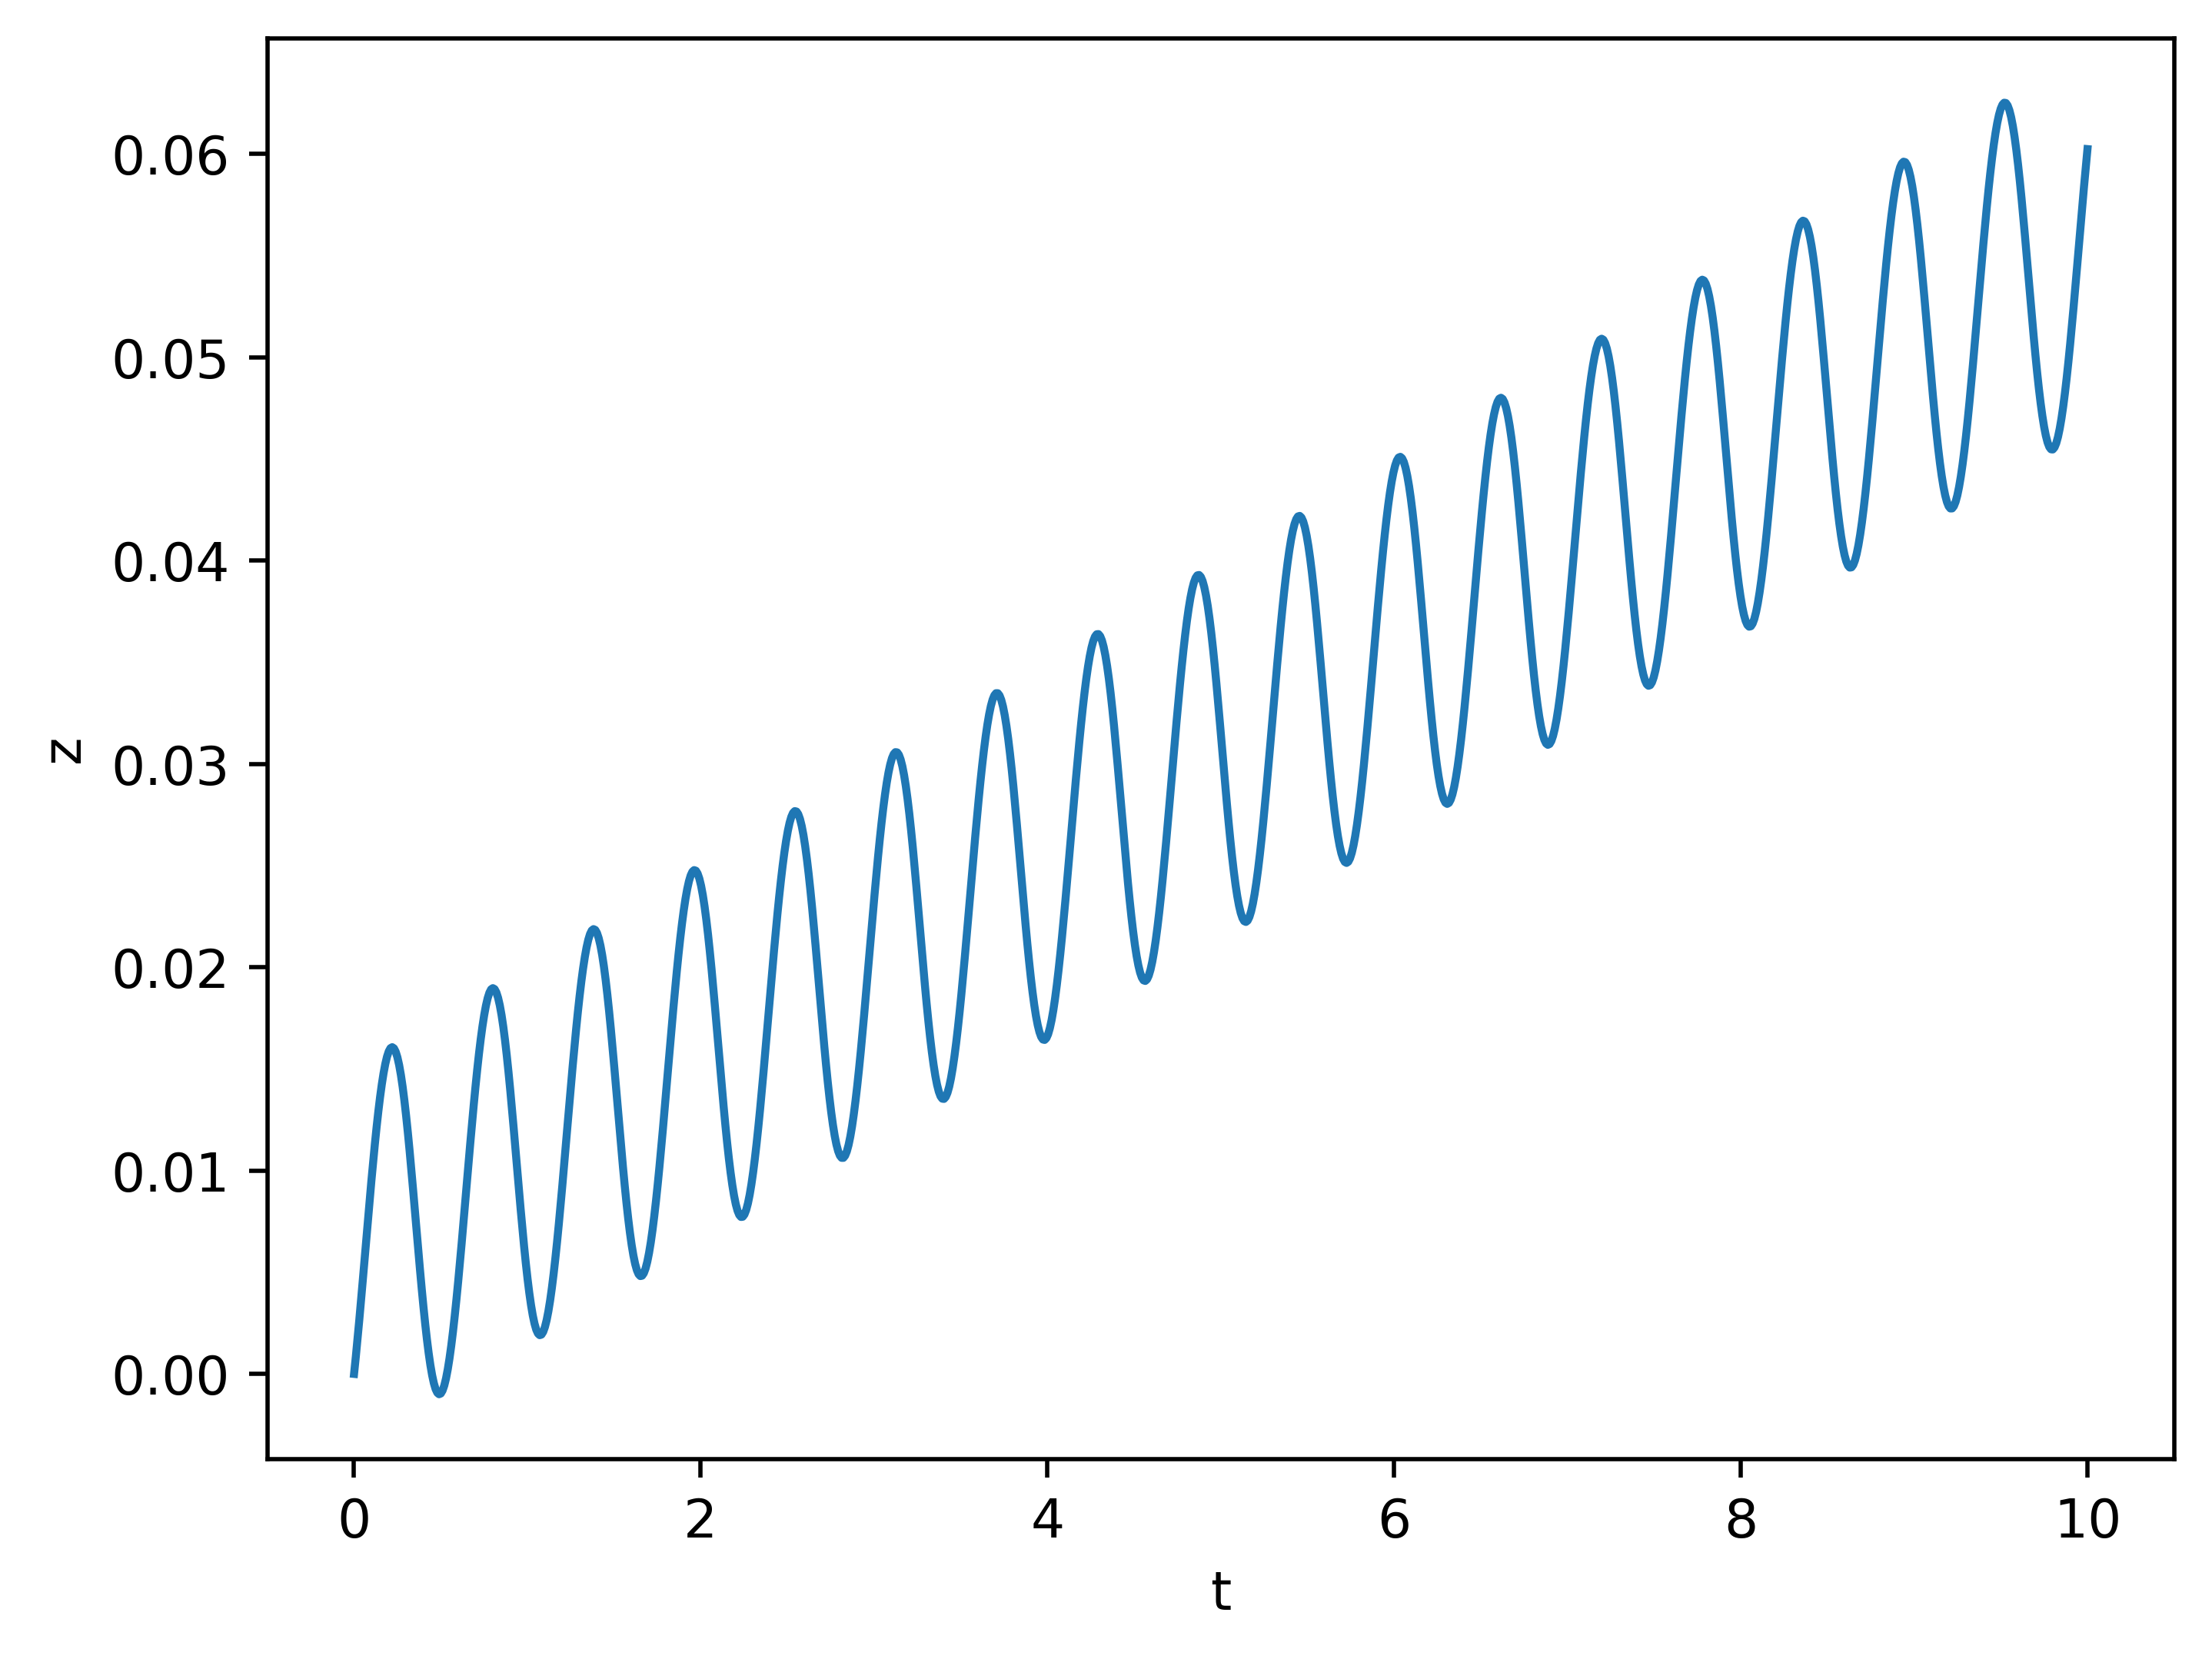

In [13]:
plt.figure(dpi = 500)
plt.xlabel("t")
plt.ylabel("z")
plt.plot(t, sol[0].T[3])
plt.savefig('C:\\Users\\ss\\Downloads\\varying_field.png', facecolor = 'w', dpi = 500)
plt.show()

In [15]:
def da2dt(t, S):
    k = 1
    l = 2
    vx, x, vy, y, vz, z = S
    r2 = (z**2+(x-0.1)**2)
    return [l*vy*(0.1-x)/r2-k*vz/x     , vx,
            l*z*vz/r2 - l*vx*(0.1-x)/r2, vy,
             k*vx/x   - l*vy*z/r2      , vz]
a2_0 = (0.06, 0.1, 1, 0, 0.08, 0.02)

In [16]:
t=np.linspace(0, 10, 1000)
sol2 = odeint(da2dt, y0=a2_0, t=t, tfirst=True, full_output=True)

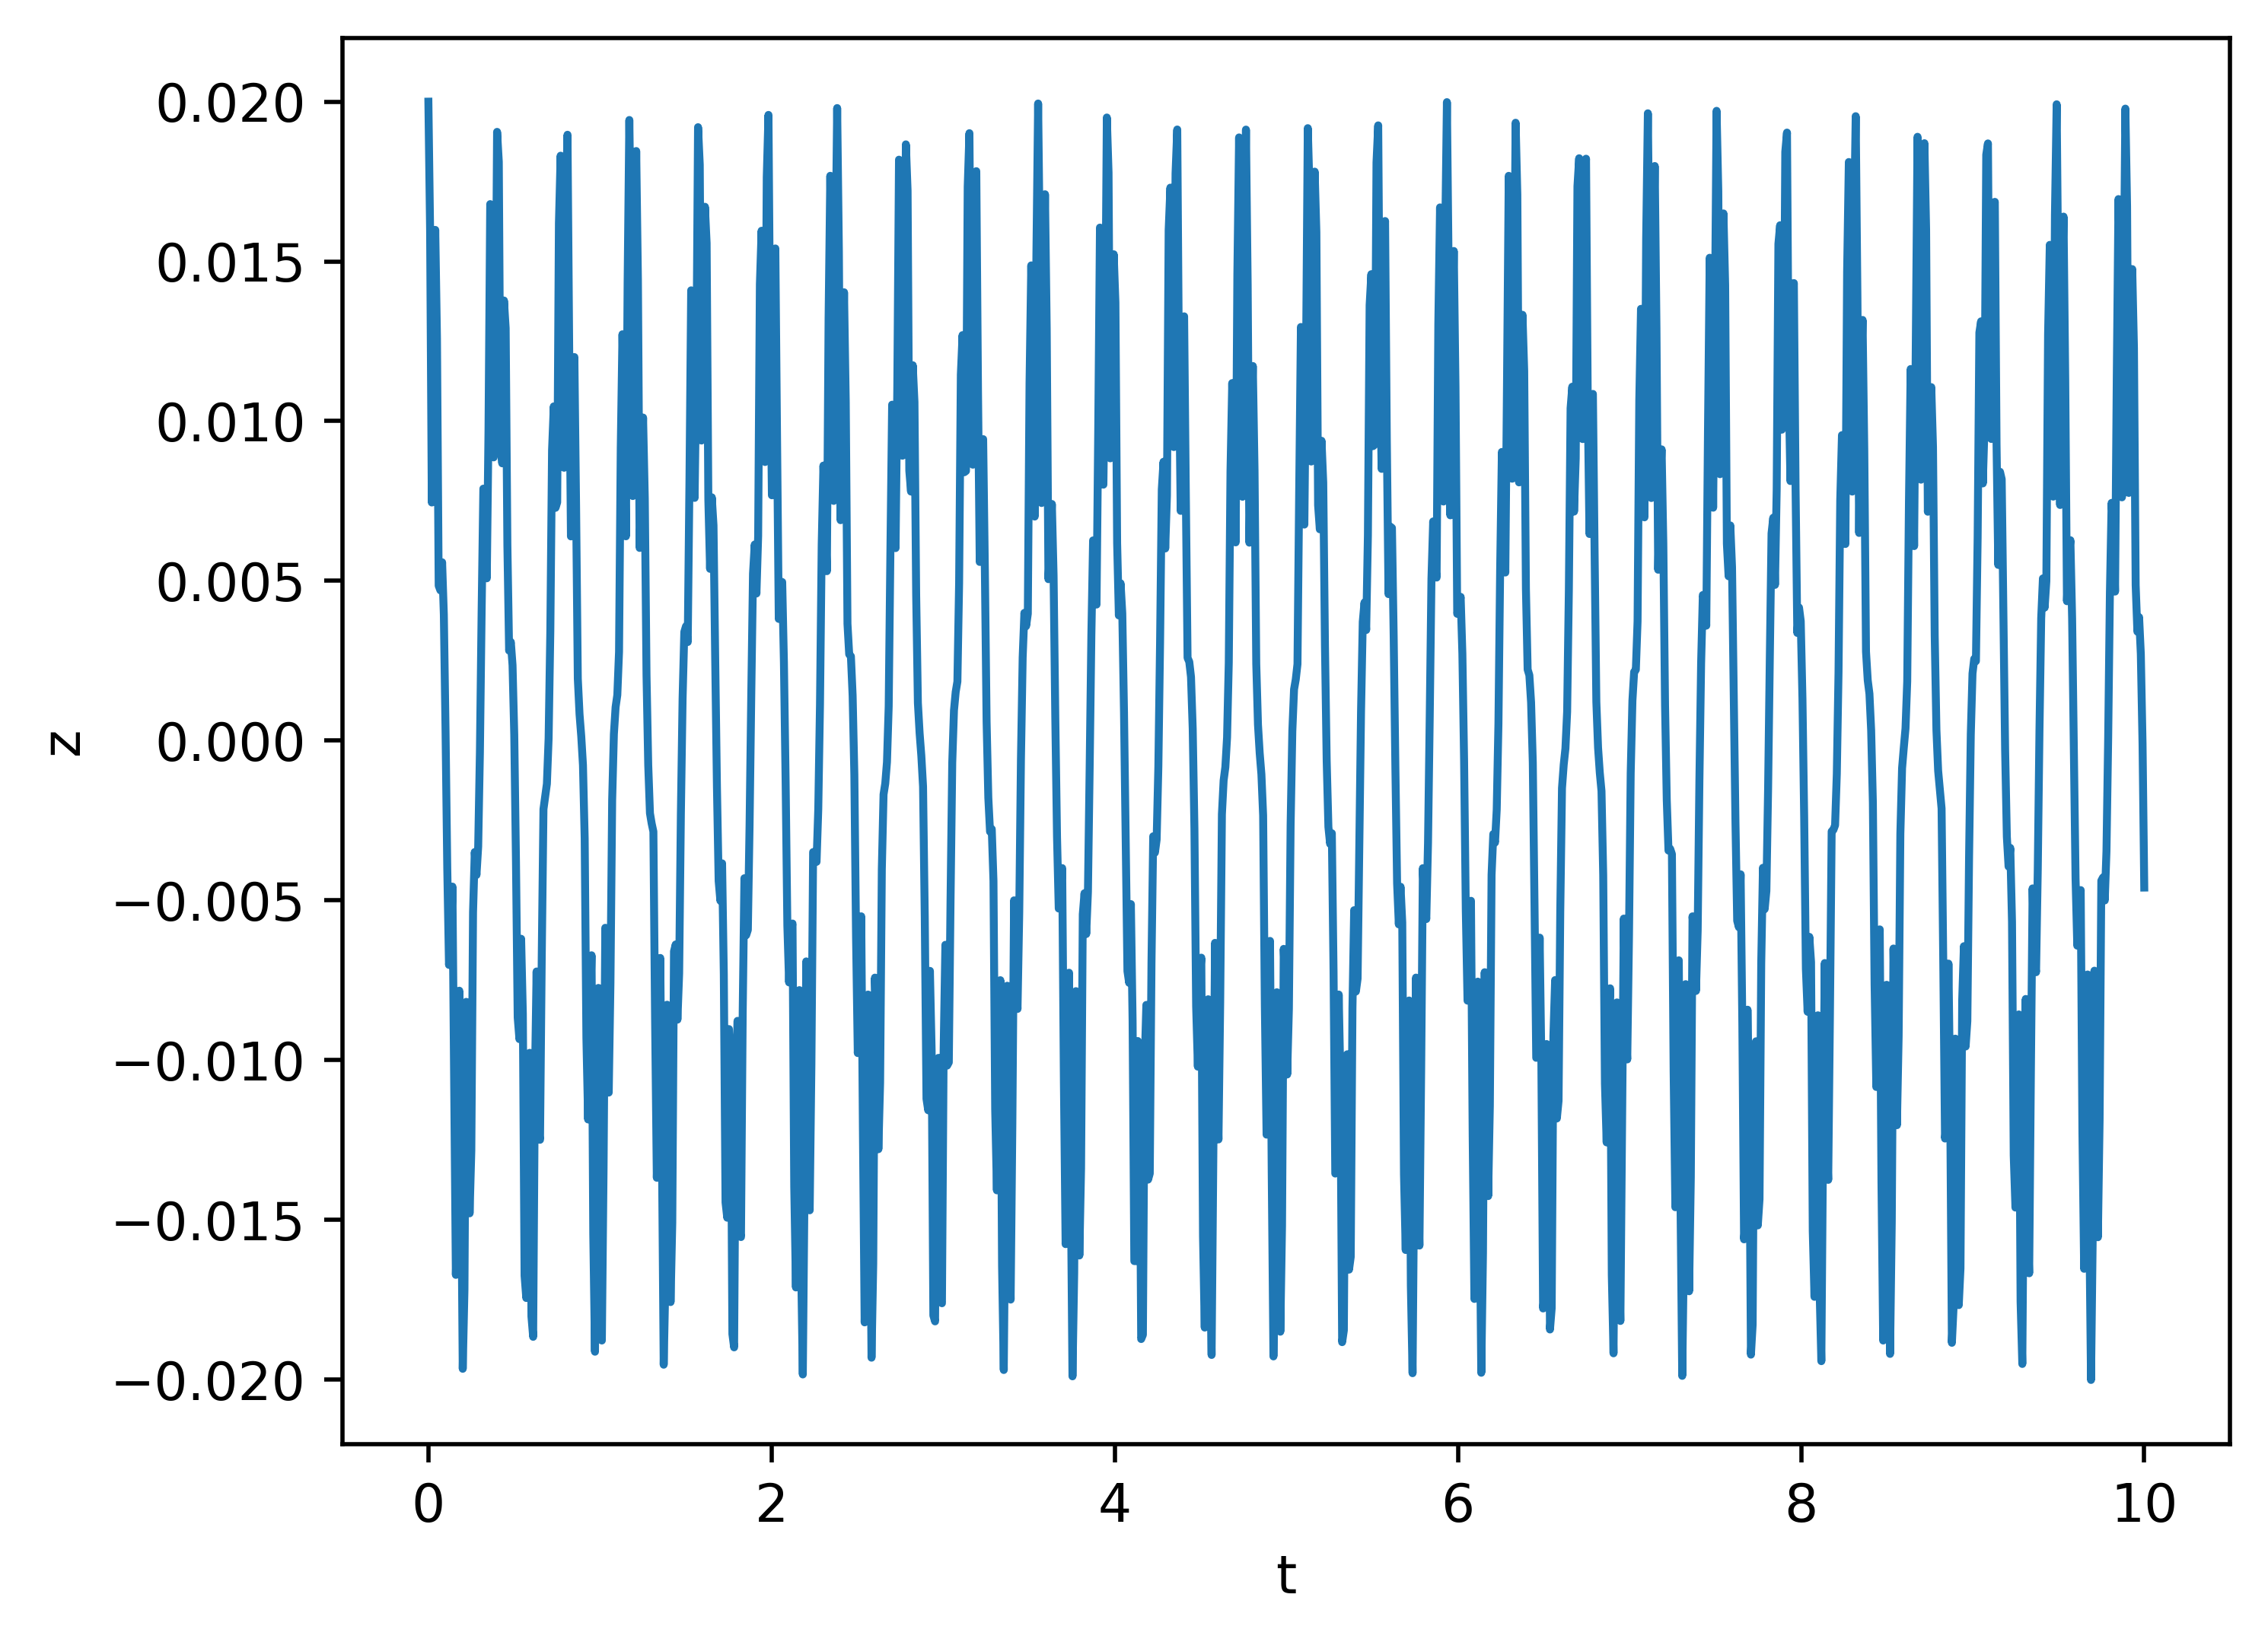

In [18]:
plt.figure(dpi = 500)
plt.xlabel("t")
plt.ylabel("z")
plt.plot(t, sol2[0].T[5])
plt.savefig('C:\\Users\\ss\\Downloads\\tokamak-correction.png', facecolor = 'w', dpi = 500)
plt.show()

In [19]:
f1 = lambda x: (6+3*np.sin(100*x))*np.cos(x)
f2 = lambda y: (6+3*np.sin(100*y))*np.sin(y)
f3 = lambda z: 3*np.cos(100*z)
I = 1000
mu_0 = 1e-7
lami = -1*np.pi
lamf = 1*np.pi
N = 1000
lam = np.linspace(lami, lamf, 3*N + 1)

In [20]:
def derivative_5(fun, u, h):
    return (-25 * fun(u) + 48*fun(u+h) -36*fun(u+2*h) +16*fun(u+3*h) -3*fun(u+4*h))/(12*h)
@njit
def __(F, N, x):
    ans = 0
    for i in range(0, 3*N, 3):
        ans += (x[3]-x[0])*(F[i] + 3*F[i+1] + 3*F[i+2] + F[i+3])/8
    return ans

def simpson_38(F, x1, x2, N):
    x = np.linspace(x1, x2, 3*N + 1)
    # F = f(x)
    return __(F, N, x)

In [21]:
def integrated(r, lam, f1, f2, f3):
    f1_x = derivative_5(f1, lam, 0.001)
    f2_y = derivative_5(f2, lam, 0.001)
    f3_z = derivative_5(f3, lam, 0.001)
    r_1  = np.array([r[0] - f1(lam), r[1] - f2(lam), r[2] - f3(lam)])
    R2 = r_1[0]**2 + r_1[1]**2+r_1[2]**2
    return (1/np.sqrt(R2)**3)*np.array([r_1[2]*f2_y - r_1[1]*f3_z,
                                                r_1[0]*f3_z - r_1[2]*f1_x,
                                                r_1[1]*f1_x - r_1[0]*f2_y])

In [22]:
def B(pos, f1, f2, f3, lami, lamf, N, I = 1): 
    lam = np.linspace(lami, lamf, 3*N + 1)
    return I*mu_0*np.array([simpson_38(integrated(pos, lam, f1, f2, f3)[0], lami, lamf, N),
                                             simpson_38(integrated(pos, lam, f1, f2, f3)[1], lami, lamf, N),
                                             simpson_38(integrated(pos, lam, f1, f2, f3)[2], lami, lamf, N)])

In [23]:
f1_2 = lambda x: 6*np.cos(x)
f2_2 = lambda y: 6*np.sin(y)
f3_2 = lambda z: 0*z

In [24]:
B2 = lambda pos:B(pos, f1, f2, f3, lami, lamf, N) + B(pos, f1_2, f2_2, f3_2, lami, lamf, N)

In [26]:
# np.linalg.norm(B2([6, 0, 1]))

In [27]:
def da_expdt(t, S):
    vx, x, vy, y, vz, z = S
    v = np.array([vx, vy, vz])
    a = 1e7*np.cross(v, B2([x, y, z]))
    return [a[0], vx,
            a[1], vy,
            a[2], vz]
a_exp_0 = (0, 5.9, 10, 0, 0.0, 0.01)

In [28]:
tplt=np.linspace(0, 5, 1000)
sol = odeint(da_expdt, y0=a_exp_0, t=tplt, tfirst=True)

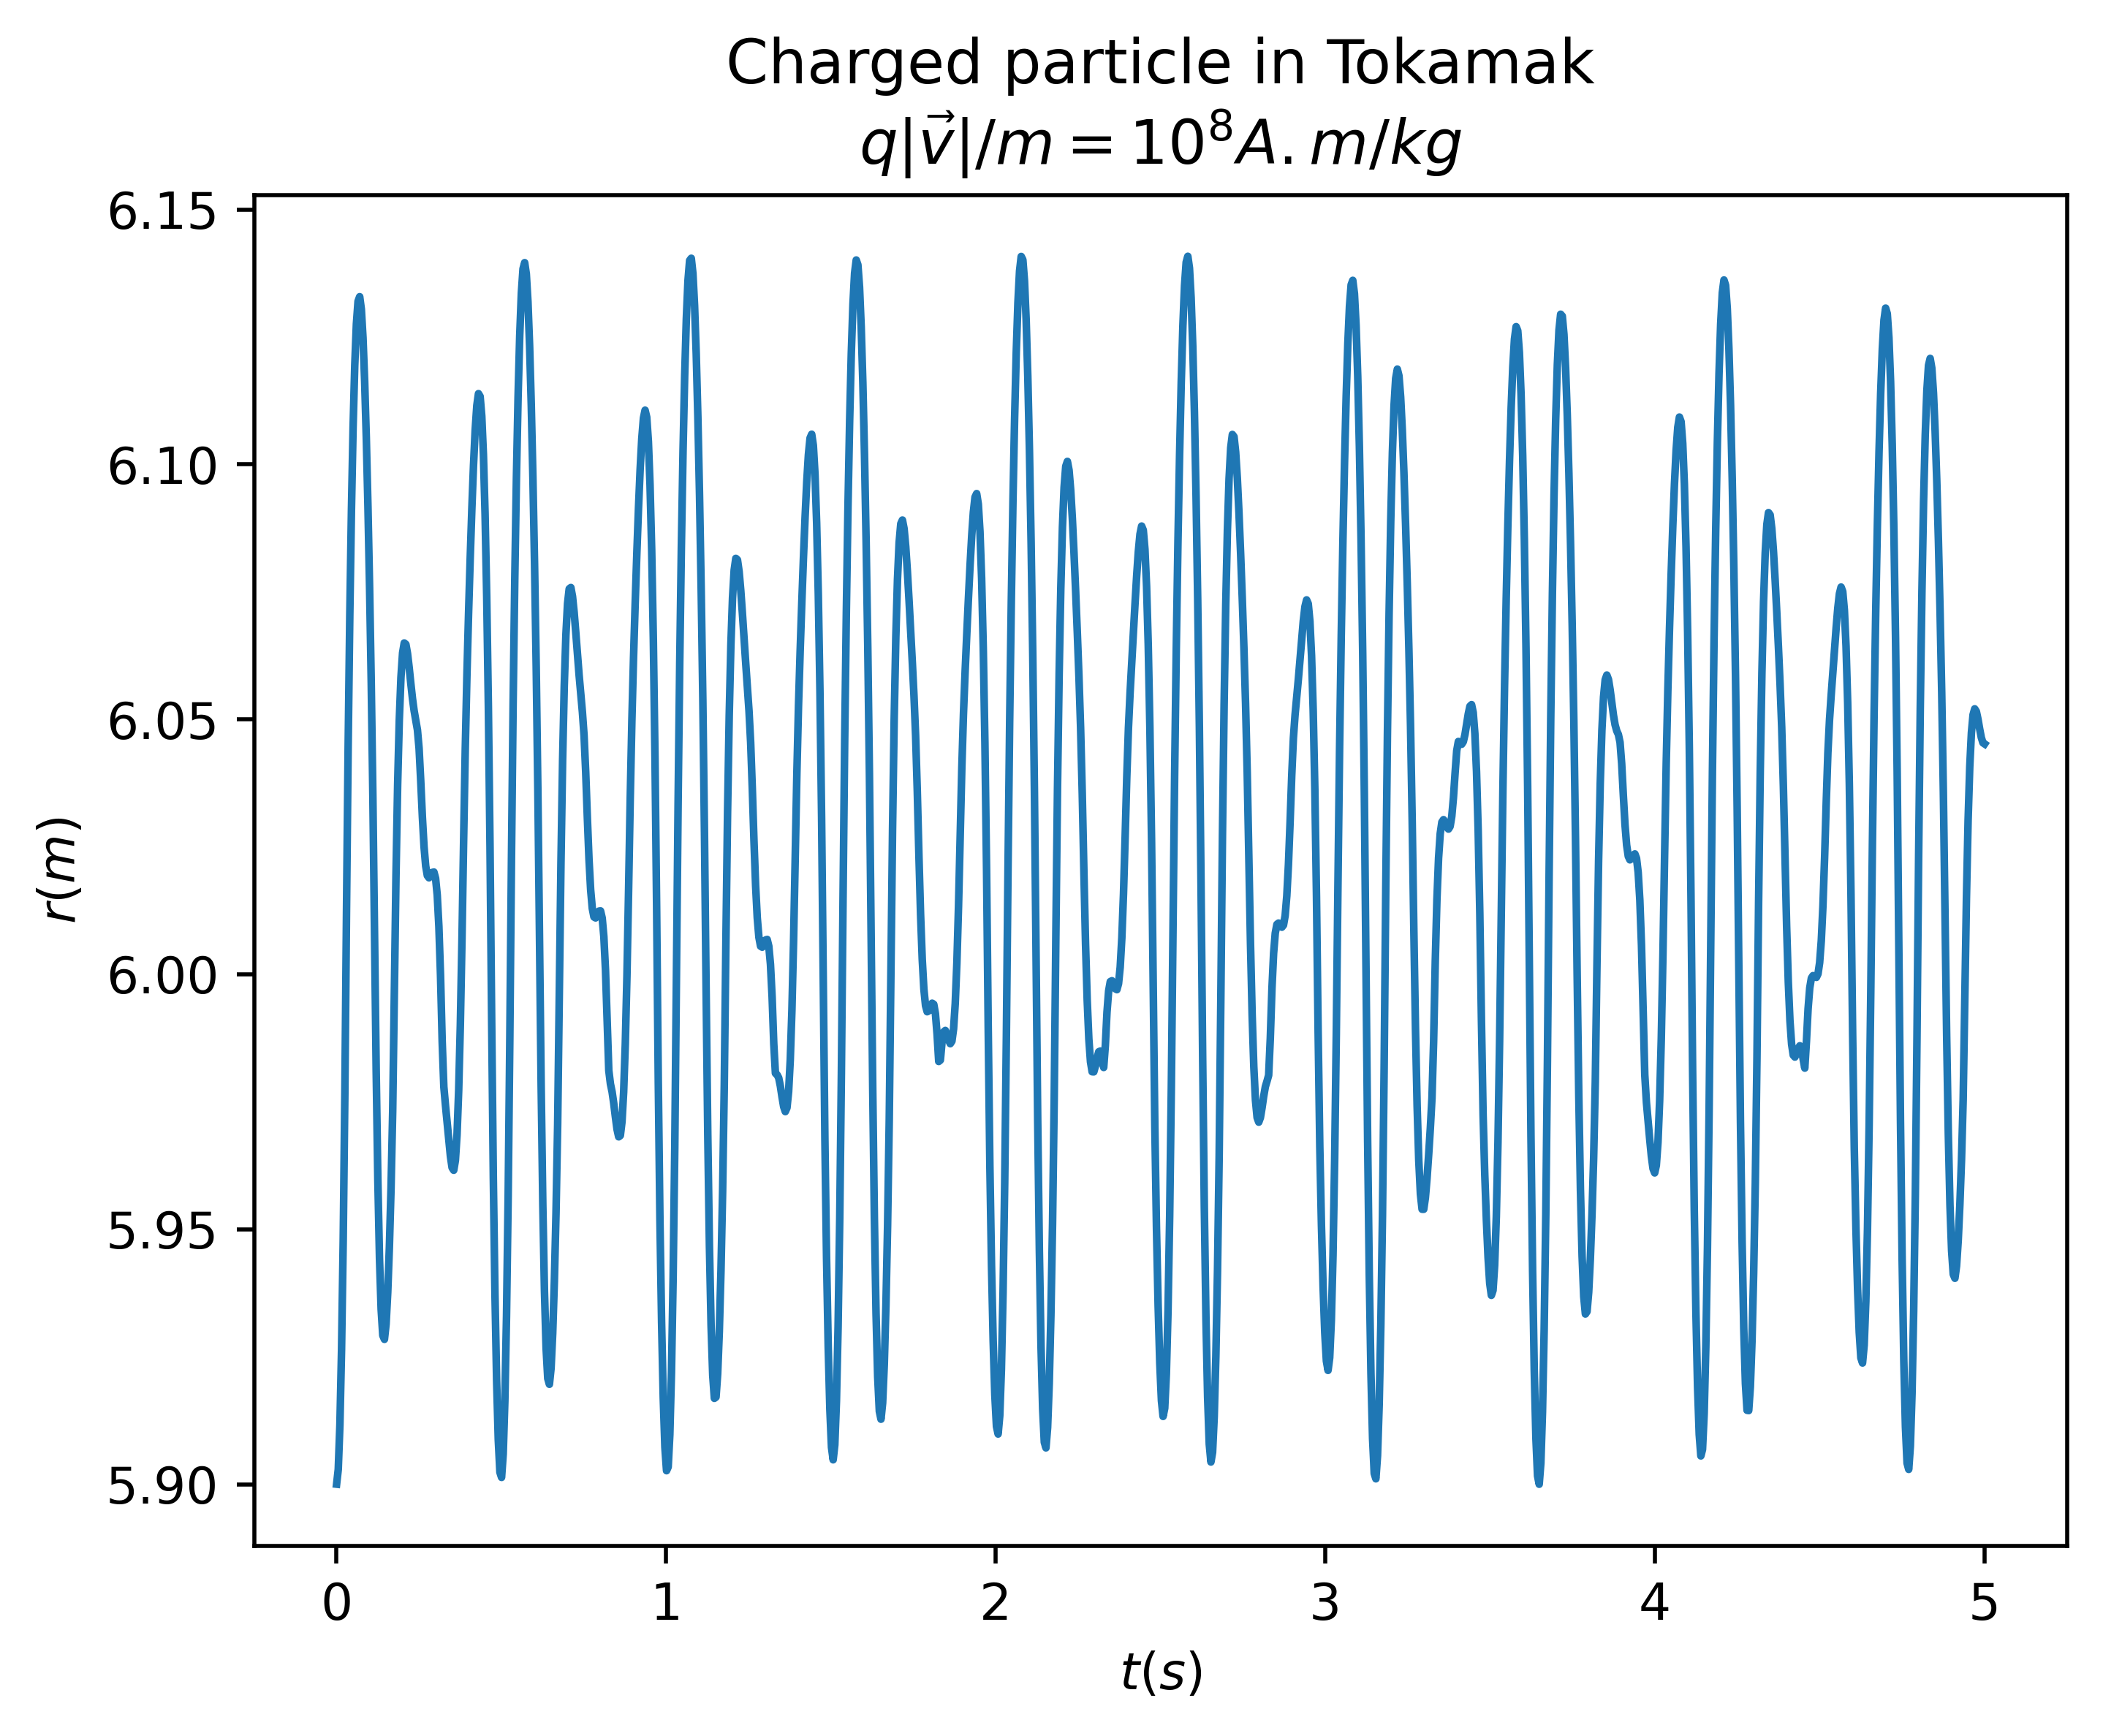

In [32]:
plt.figure(dpi = 500)
plt.title("Charged particle in Tokamak\n$q|\\vec{v}|/m = 10^{8}A.m/kg$")
plt.ylabel('$r(m)$')
plt.xlabel('$t(s)$')
plt.plot(tplt, np.sqrt(sol.T[1]**2+sol.T[3]**2+sol.T[5]**2))
plt.savefig('C:\\Users\\ss\\Downloads\\Project1_charged_particle_in_tokamak.png', facecolor = 'w', dpi = 500, bbox_inches = "tight")
plt.show()